# 【第２回目　課題１】PyTorchを用いた深層学習 (1): 全結合編

第2回目の課題１では，前回の課題1と同じ問題に対して，最も簡単な深層学習フレームワークと言われている<a href="https://pytorch.org/">PyTorch</a>を用いて，取り組んでみましょう．

まずは，<a href="https://pytorch.org/tutorials/">PyTorchの公式チュートリアル</a>を見てみましょう．

PyTorchには，<a href="https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_nn.html">Sequential model</a> と 
<a href="https://keras.io/ja/getting-started/functional-api-guide/">nn.Moduleを継承する</a>，２つの書き方があります．

レイヤーを単純につなげていくだけの簡単なモデルの場合は，Sequential model で十分ですので，今回はSequential model を使うことにします．

課題としては，前回同様に
全結合層＋ReLU＋2乗誤差関数 のネットワークを考えてみます．
全結合層を使って任意の関数の近似を行います．

最初に Pytorch の実行に必要な モジュールを import します．

In [1]:
import numpy as np
import time

import torch
import torch.nn as nn
import torch.optim as optim

まず，近似する関数の定義を行って，学習データ(training data)，検証データ(validation data)を生成します．データの定義は，基本的に前回と同じですが，学習で使うデータは，<a href="https://pytorch.org/docs/stable/tensors.html">torch.Tensor型</a>にしておく必要があります．ここでは，nupmyから変換する <a href="https://pytorch.org/docs/stable/torch.html#torch.from_numpy">from_numpy関数</a>を利用しています．

In [2]:
def f(x):
    return 0.5*(x-2)**2-5

X_train0=np.arange(-10,10,0.01,dtype=np.float32)
Y_train0= f(X_train0)
# X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
X_train=torch.from_numpy(np.reshape(X_train0,[-1,1])) # , requires_grad=True)   # (2000,)  -> (2000,1)
Y_train=torch.from_numpy(np.reshape(Y_train0,[-1,1])) 
num_train=np.size(X_train0)

# テスト用の x も準備します．
X_val0=np.arange(-8,8,0.1,dtype=np.float32)
Y_val0= f(X_val0)
X_val=torch.from_numpy(np.reshape(X_val0,[-1,1]))
Y_val=torch.from_numpy(np.reshape(Y_val0,[-1,1]))
num_val=np.size(X_val0)

次に学習中にグラフを表示するための ShowGraph classを定義しておきます．(Kerasはこれをコールバック関数として指定しますが，PyTorchではユーザが呼び出します．）

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

# 学習途中のlossなどのグラフ表示を行う ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph:
    def __init__(self,model,max_epoch):
        # 表示エリアの設定
        self.fig=plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 50])
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.fig2.set_title('y=0.5(x-2)^2-5')
        self.fig2.set_ylabel('f(x)')
        self.fig2.set_xlabel('x')
        self.model=model
        self.max_epoch=max_epoch
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.losses_val=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, loss, val_loss):
        self.n_epoch.append(epoch)
        self.losses.append(loss)
        self.losses_val.append(val_loss)     
        self.loss_val=val_loss
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"b")
        self.fig1.plot(self.n_epoch,self.losses_val,"r")
        with torch.no_grad():   # backwardは計算しないので，計算途中の値を記録しないようにする．
            Y_pred=self.model(X_val)
        x0=np.reshape(X_val0,[-1])
        y0=torch.reshape(Y_pred,[-1]).detach().cpu().numpy()
        self.fig2.plot(x0,y0,"b")
        self.fig2.plot(x0,f(x0),"r")
        display.display(self.fig)
        if epoch<self.max_epoch-1:
            self.fig2.cla()
    
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss_val:",self.loss_val) 
        print('Time: ',time.time()-self.start)

さあ，いよいよモデルを定義します．
前回と違って，当然ですが，全結合層クラスはPyTorchに含まれているので，実装は不要です．
PyTorchでは，nn.Linear が fcに相当します．
```python
  nn.Linear(1,20)
```

次に学習するネットワークを記述してみましょう．
前回は以下のように1x20+ReLU +20x20+ReLU + 20x1 の３層となっていました．
```python
fc1=Fc(1,20)
fc2=Fc(20,20)
fc3=Fc(20,1,False)
```
Sequential モデルでは，nn.Sequential の引数の中に，連続するレイヤーを記述します．
nn.Linear が全結合，nn.ReLuがReLU関数です．

In [36]:
model = nn.Sequential(
    nn.Linear(1, 20),
    nn.ReLU(),
    nn.Linear(20, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
)

モデルを表示するには，
```python
print(model)
```
とするだけでOKです．

In [37]:
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=1, bias=True)
)


次に，<a href="https://pytorch.org/docs/stable/nn.functional.html#loss-functions">損失関数(loss function)</a>と <a href="https://pytorch.org/docs/stable/optim.html">最適化手法(optimizer)</a> の準備を行います．

損失関数は，回帰問題なので，<a href="https://pytorch.org/docs/stable/nn.functional.html#mse-loss">最小２乗誤差(mean_squared_error)</a> を使います．最適化手法(optimizer)は，<a href="https://pytorch.org/docs/stable/optim.html?highlight=sgd#torch.optim.SGD">標準的な SGD</a>を使います．
なお，標準SDGとモーメンタムSDGの区別はありません．momentum rate の指定で区別できます．デフォルトでは，momentum rate=0.0 ですので，標準SDGになります．mometum=0.9 とすれば，一般的なモーメンタムSDGとなります．weight_decay は，Weight Decay という重みの正則化パラメータです．1e-6 など通常は小さい値を指定しますが，最初はweight_decayを使わないことにして 0 としておきます．

In [38]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.0, weight_decay=0.0)

学習を始める前に，モデルとデータをGPUに転送しておきます．これをしないとGPUがあっても，CPU計算となってしまい，時間がかかってしまいます．
```python
model.to('cuda')
``` 
とします．実際には，GPUが使えるかをチェックして，GPUがあれば，変数deviceに'cuda'を，なければ'cpu'を入れて，model.to(device) とするのが一般的です．('gpu'ではなくて，NVIDIAのGPU演算ライブラリの名称 'cuda'を指定するので，注意が必要です．）

PyTorchでは，GPUを使う場合には明示的にGPUにデータやモデルを転送する必要があります．
学習モデルをsaveする場合には，CPUに一度GPUからモデルを戻してやる必要があります．
この様に，PyTorchでGPUを使う場合には，データやモデルが今，GPU/CPUのどちらにあるか
を常に意識する必要があります．

(なお，Kerasでは，GPUがあれば自動的にGPUにモデルやデータが転送されて，GPU上で計算が行われますので，ユーザは特にGPU/CPUの区別を気にする必要はありません．）

In [39]:
# GPU があれば，GPU にmodelを転送.
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
X_train=X_train.to(device)
Y_train=Y_train.to(device)
X_val=X_val.to(device)
Y_val=Y_val.to(device)

なお，GPUが複数ある環境では，
```python
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2"
```
として，最初からPyTorchで利用可能なGPUを限定してしまう方法と，
```python
device='cuda:1' 
```
の様に cuda: の後にGPU ID (0から始まる)を記述する方法があります．

他に標準GPUのIDを指定する方法もあります．
```python
torch.cuda.set_device(3) 
```
とすると，これ以降, 'cuda' が 'cuda:3' と同じになります．

torch.cuda.device_count() を使うと利用可能なGPUを表示することができます．
最初の方法で環境変数で限定してしまうと指定したGPUの数が表示されますが，
他の方法ではシステムの全てのGPU数が表示されます．

詳しくは，<a href="https://pytorch.org/docs/stable/cuda.html">torch.cuda</a> のドキュメントを見ましょう．

In [40]:
import torch
torch.cuda.device_count()

2

いよいよ，学習です．

PyTorchでは，Kerasと違って自分で学習ループを書く必要があります．

epoch数 と batch_sizeを決めて，(epoch数)×ceil(学習データ数/batch_size)回だけ
ループを回してやる必要があります．(ceilは小数点以下切り上げ)

学習ループ内では，
1. 学習データの順伝搬
1. 誤差勾配の逆伝搬
1. SGDなどのoptimizerで，重みをupdate
の3つの処理が必要です．
このために，
```python
loss = loss_fn(Y_pred, Y_train)
optimizer.zero_grad()
loss.backward()
optimizer.step()
```
とします．勾配は元の値に加算されるので，optimizer.zero_grad() として，必ず back-propagationの前にクリアしておきます．

さらに学習途中の様子を見るために，ここでは，5エポック毎に，
学習途中のモデルでテストデータを評価して，そのグラフ(つまり，学習途中の$y=f(x)$)を描画するとともに，training loss, test lossを両方グラフに表示します．

loss_val: 4.760125160217285
Time:  16.27922773361206


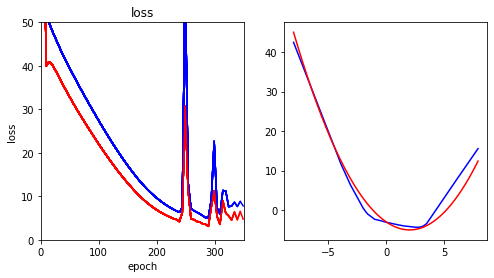

In [9]:
num_epoch=350
show_graph=ShowGraph(model,num_epoch)
show_graph.on_train_begin();

for t in range(num_epoch):
    Y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(Y_pred, Y_train)
    if t % 5 == 4: # 5epoch毎にグラフを描画
        Y_pred = model(X_val)
        vloss = loss_fn(Y_pred, Y_val)
        show_graph.on_epoch_end(t,loss.item(),vloss.item())

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

### 課題1
以下の小問の(1)-(2)を解答せよ．
(再実行する場合は，モデル定義から下だけ実行すれば大丈夫です．）

1. OptimizerをモーメンタムSDG (momentum=0.9), RMSprop, Adamに変更して，ノーマルなSDGとの違いを観察せよ．
1. 関数 $f(x)$ を自由に書き換え，実行せよ．2通りの $f(x)$ で試してみよ．

## 1. optimizerの定義と図の表示部分のみ、以下で置き換えて実行

In [12]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0)

loss_val: 0.060045089572668076
Time:  16.367934942245483


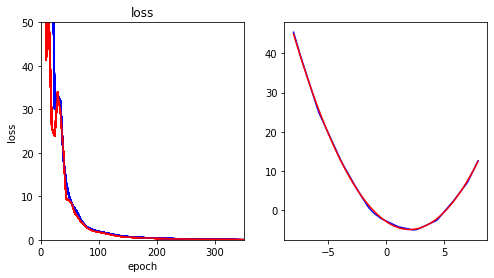

In [15]:
num_epoch=350
show_graph=ShowGraph(model,num_epoch)
show_graph.on_train_begin();

for t in range(num_epoch):
    Y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(Y_pred, Y_train)
    if t % 5 == 4: # 5epoch毎にグラフを描画
        Y_pred = model(X_val)
        vloss = loss_fn(Y_pred, Y_val)
        show_graph.on_epoch_end(t,loss.item(),vloss.item())

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

In [18]:
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters())

loss_val: 1.1927484273910522
Time:  16.756016969680786


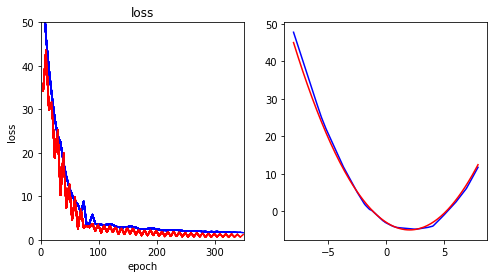

In [21]:
num_epoch=350
show_graph=ShowGraph(model,num_epoch)
show_graph.on_train_begin();

for t in range(num_epoch):
    Y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(Y_pred, Y_train)
    if t % 5 == 4: # 5epoch毎にグラフを描画
        Y_pred = model(X_val)
        vloss = loss_fn(Y_pred, Y_val)
        show_graph.on_epoch_end(t,loss.item(),vloss.item())

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

In [24]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

loss_val: 11.216859817504883
Time:  15.964597702026367


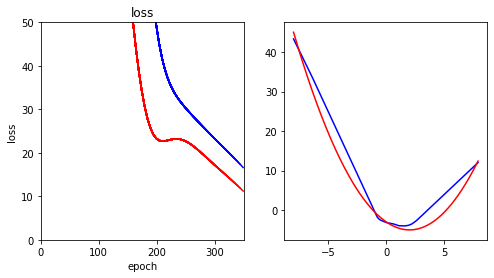

In [27]:
num_epoch=350
show_graph=ShowGraph(model,num_epoch)
show_graph.on_train_begin();

for t in range(num_epoch):
    Y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(Y_pred, Y_train)
    if t % 5 == 4: # 5epoch毎にグラフを描画
        Y_pred = model(X_val)
        vloss = loss_fn(Y_pred, Y_val)
        show_graph.on_epoch_end(t,loss.item(),vloss.item())

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

## 2.　関数定義部分のみ、以下に置き換えて実行

In [28]:
def f(x):
    return (x)**2-5

X_train0=np.arange(-10,10,0.01,dtype=np.float32)
Y_train0= f(X_train0)
# X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
X_train=torch.from_numpy(np.reshape(X_train0,[-1,1])) # , requires_grad=True)   # (2000,)  -> (2000,1)
Y_train=torch.from_numpy(np.reshape(Y_train0,[-1,1])) 
num_train=np.size(X_train0)

# テスト用の x も準備します．
X_val0=np.arange(-8,8,0.1,dtype=np.float32)
Y_val0= f(X_val0)
X_val=torch.from_numpy(np.reshape(X_val0,[-1,1]))
Y_val=torch.from_numpy(np.reshape(Y_val0,[-1,1]))
num_val=np.size(X_val0)

loss_val: 32.0737419128418
Time:  16.32233428955078


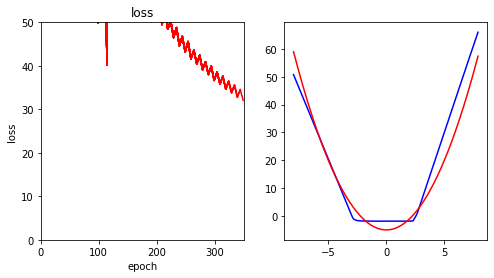

In [34]:
num_epoch=350
show_graph=ShowGraph(model,num_epoch)
show_graph.on_train_begin();

for t in range(num_epoch):
    Y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(Y_pred, Y_train)
    if t % 5 == 4: # 5epoch毎にグラフを描画
        Y_pred = model(X_val)
        vloss = loss_fn(Y_pred, Y_val)
        show_graph.on_epoch_end(t,loss.item(),vloss.item())

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph

In [35]:
def f(x):
    return x**2+3*x-8

X_train0=np.arange(-10,10,0.01,dtype=np.float32)
Y_train0= f(X_train0)
# X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
X_train=torch.from_numpy(np.reshape(X_train0,[-1,1])) # , requires_grad=True)   # (2000,)  -> (2000,1)
Y_train=torch.from_numpy(np.reshape(Y_train0,[-1,1])) 
num_train=np.size(X_train0)

# テスト用の x も準備します．
X_val0=np.arange(-8,8,0.1,dtype=np.float32)
Y_val0= f(X_val0)
X_val=torch.from_numpy(np.reshape(X_val0,[-1,1]))
Y_val=torch.from_numpy(np.reshape(Y_val0,[-1,1]))
num_val=np.size(X_val0)

loss_val: 78.57356262207031
Time:  15.868560791015625


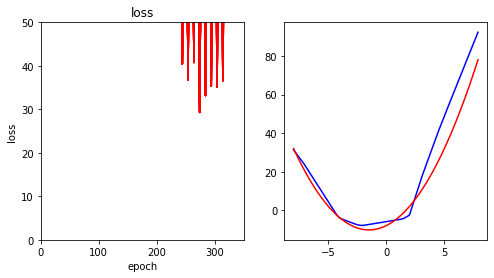

In [41]:
num_epoch=350
show_graph=ShowGraph(model,num_epoch)
show_graph.on_train_begin();

for t in range(num_epoch):
    Y_pred = model(X_train)

    # Compute and print loss.
    loss = loss_fn(Y_pred, Y_train)
    if t % 5 == 4: # 5epoch毎にグラフを描画
        Y_pred = model(X_val)
        vloss = loss_fn(Y_pred, Y_val)
        show_graph.on_epoch_end(t,loss.item(),vloss.item())

    # backwardする前に，必ず一度勾配をクリアする．デフォルトでは勾配は足し算される．
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

del show_graph